In [341]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [342]:
# read in all the words
# Read the file and split into words
# Read the file and split into words
with open('nomi_test.txt', 'r') as f:
    text = f.read()
    words = text.split()


words[:6]



['beateannamargarete',
 'beateannamargarete',
 'beateannamargarete',
 'beateannamargarete',
 'beateannamargarete',
 'beateannamargarete']

In [343]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
# filter out unwanted characters
chars = [c for c in chars]
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
stoi['1'] = 28
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
lengths = [len(w) for w in words]   
print(max(lengths))
#print the longest word
print(words[lengths.index(max(lengths))])

#remove all instances of z from every word
#words = [w.replace('z', '') for w in words]



{1: 'a', 2: 'b', 3: 'e', 4: 'g', 5: 'm', 6: 'n', 7: 'r', 8: 't', 0: '.', 28: '1'}
10
18
beateannamargarete


In [344]:
# build the dataset
block_size = 16 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(1*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([152, 16]) torch.Size([152])
torch.Size([0]) torch.Size([0])
torch.Size([19, 16]) torch.Size([19])


In [345]:
# MLP revisited
n_embd = 12 # the dimensionality of the character embedding vectors
n_hidden = 2000 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

print(C.shape)

408130
torch.Size([10, 12])


In [367]:
# same optimization as last time
batch_size = 1
lossi = []

# define lr and iterations arrays
lr = [0.1, 0.01, 0.001]
iterations = [0, 1000000, 0]
total_iterations = 0 # keep track of total iterations

# loop through pairs of lr and iterations
for lr, it in zip(lr, iterations):
    for i in range(it):
        
        
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
        
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) + 0.001 * (W1**2).mean() + 0.001 * (W2**2).mean() # cross-entropy loss
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'Learning rate: {lr}, Iteration number: {total_iterations}/{sum(iterations)}, Loss: {loss.item():.4f}')
        if i % 100 == 0:
            lossi.append(loss.log10().item())
        total_iterations += 1
        


Learning rate: 0.01, Iteration number: 0/1000000, Loss: nan
Learning rate: 0.01, Iteration number: 10000/1000000, Loss: nan


[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [331]:
print(len(Xtr))

152


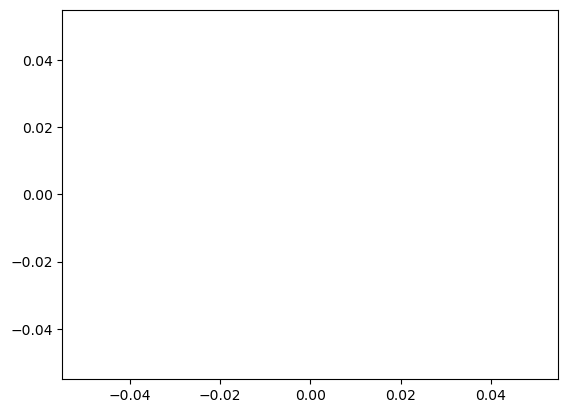

In [332]:
plt.plot(lossi)
lossi_means = [sum(lossi[i:i+100])/100 for i in range(len(lossi)-100)]
plt.plot(lossi_means)

In [363]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train nan


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [366]:
#sample the model 
@torch.no_grad()
def sample():
    names = []
    for i in range(50):
        context = [0] * block_size
        name = []
        for i in range(20):
            context = torch.tensor(context).unsqueeze(0)
            emb = C[context]
            embcat = emb.view(emb.shape[0], -1)
            hpreact = embcat @ W1 + b1
            hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
            h = torch.tanh(hpreact)
            logits = h @ W2 + b2
            probs = F.softmax(logits, 1)
            next_char = torch.multinomial(probs, 1).squeeze()
            if next_char == 0:
                break
            name.append(itos[next_char.item()])
            context = context.squeeze().tolist()
            context = context[1:] + [next_char.item()]
            
        names.append(''.join(name))
    return names

generated_names = sample()
#now print on different lines
for name in generated_names:
    if name not in words:
        print(name)




RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [231]:
#Save the model
torch.save({
    'C': C,
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2,
    'bngain': bngain,
    'bnbias': bnbias,
    'bnmean_running': bnmean_running,
    'bnstd_running': bnstd_running
}, 'model_nomi_italiani.pt')



In [ ]:
#load the model and sample
model = torch.load('model.pt')
C = model['C']
W1 = model['W1']
b1 = model['b1']
W2 = model['W2']
b2 = model['b2']
bngain = model['bngain']
bnbias = model['bnbias']
bnmean_running = model['bnmean_running']
bnstd_running = model['bnstd_running']

sample()
